In [1]:
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pmdarima import auto_arima



# DICKEY FULLER TEST

In [4]:
# cargar dataset
df = pd.read_csv("processed\data_processed_final.csv")


# Lista para guardar los resultados
results = []

# Iterar por jugador
for player in df["Player"].unique():
    player_data = df[df["Player"] == player]
    performance_series = player_data["last_performance"].values
    
    # Realizar el test de Dickey-Fuller
    adf_result = adfuller(performance_series)
    
    # Guardar los resultados
    result_dict = {
        "Player": player,
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "Critical Values": adf_result[4],
        "Is Stationary": adf_result[1] < 0.05  # Estacionariedad si p-valor < 0.05
    }
    results.append(result_dict)

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Mostrar resultados iterando por jugador
for idx, row in results_df.iterrows():
    print(f"Player: {row['Player']}")
    print(f"ADF Statistic: {row['ADF Statistic']}")
    print(f"p-value: {row['p-value']}")
    print(f"Critical Values: {row['Critical Values']}")
    print(f"Is Stationary: {row['Is Stationary']}")
    print("\n")

Player: Ferran
ADF Statistic: -3.8305736839098357
p-value: 0.0026095474934785296
Critical Values: {'1%': -3.4521902441030963, '5%': -2.871158406898617, '10%': -2.5718948388228586}
Is Stationary: True


Player: Gerard Moreno
ADF Statistic: -3.74230768820806
p-value: 0.0035559182538531732
Critical Values: {'1%': -3.453922368485787, '5%': -2.871918329081633, '10%': -2.5723001147959184}
Is Stationary: True


Player: Griezmann
ADF Statistic: -4.510458732804784
p-value: 0.00018825808448329946
Critical Values: {'1%': -3.4514843502727306, '5%': -2.8708485956333556, '10%': -2.571729625657462}
Is Stationary: True


Player: Koundé
ADF Statistic: -4.638748328778486
p-value: 0.00010951481266284085
Critical Values: {'1%': -3.4513486122290717, '5%': -2.870789013306053, '10%': -2.5716978530569192}
Is Stationary: True


Player: Kubo
ADF Statistic: -3.9273604351576896
p-value: 0.0018424663164317203
Critical Values: {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}
Is Statio

# TOPICS DINAMICOS

In [39]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import re
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary
import nltk
from nltk.stem import WordNetLemmatizer
import ast



def preprocess_text(text):
        """
        Preprocesa el texto para análisis de tópicos
        """
        # Inicializar herramientas
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()

        # Convertir a minúsculas
        text = text.lower()

        # Eliminar caracteres especiales
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenizar
        tokens = word_tokenize(text)

        # Eliminar stopwords y lematizar
        tokens = [lemmatizer.lemmatize(token) for token in tokens
                if token not in stop_words and len(token) > 2]

        return tokens


def print_topic_evolution(model, periods=None):
        """
        Imprime la evolución de tópicos a lo largo del tiempo
        """
        num_time_slices = len(time_slices)
        for t in range(num_time_slices):
            print(f"\nPeríodo {t}:")
            for topic in range(model.num_topics):
                # La nueva sintaxis no usa el parámetro 'topics'
                top_terms = model.print_topics(time=t)[topic]
                print(f"Tópico {topic}: {top_terms[:5]}")

In [40]:
# Descargar recursos necesarios de NLTK español
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


df = pd.read_csv("processed\data_processed_final.csv")

dtm_results = []

for player in df["Player"].unique():
    print(f"\nJugador: {player}------------------------------------------------------")
    df = pd.read_csv("processed\data_processed_final.csv")

    df = df[df["Player"] == player]
    df['Fecha'] = pd.to_datetime(df['Fecha'])




    # Crear un nuevo dataframe vacío
    noticias_expandidas = []

    # Iterar sobre cada fila del dataframe original
    for _, row in df.iterrows():
        fecha = row['Fecha']
        # Convertir el string que representa una lista a una lista real
        lista_noticias = ast.literal_eval(row['Noticias'])
        for noticia in lista_noticias:
            noticias_expandidas.append([fecha, noticia])

    # Crear un nuevo dataframe con las noticias expandidas
    df = pd.DataFrame(noticias_expandidas, columns=['Fecha', 'Noticia'])





    


    df['processed_text'] = df['Noticia'].apply(preprocess_text)


    # Crear diccionario
    dictionary = Dictionary(df['processed_text'])

    # Filtrar términos poco frecuentes o muy comunes
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    print("\nTamaño del vocabulario:", len(dictionary))


    # Crear corpus
    corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]

    # Preparar time_slices (documentos por mes)
    df['month'] = df['Fecha'].dt.to_period('M')
    time_slices = df.groupby('month').size().tolist()
    print("\nNúmero de periodos temporales:", len(time_slices))


    # Configurar y entrenar modelo
    num_topics = 3  # Número de tópicos a detectar
    chain_variance = 0.100  # Controla la suavidad de la evolución temporal

    dtm = LdaSeqModel(
        corpus=corpus,
        time_slice=time_slices,
        num_topics=num_topics,
        id2word=dictionary,
        chain_variance=chain_variance,
        passes=10
    )


    dtm_results.append({player: dtm})

    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Jugador: Ferran------------------------------------------------------

Tamaño del vocabulario: 1169

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Gerard Moreno------------------------------------------------------

Tamaño del vocabulario: 142

Número de periodos temporales: 8


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Griezmann------------------------------------------------------

Tamaño del vocabulario: 1456

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Koundé------------------------------------------------------

Tamaño del vocabulario: 1075

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Kubo------------------------------------------------------

Tamaño del vocabulario: 578

Número de periodos temporales: 8


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Lamine Yamal------------------------------------------------------

Tamaño del vocabulario: 1774

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Lewandowski------------------------------------------------------

Tamaño del vocabulario: 2149

Número de periodos temporales: 9
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\santi\AppData\Local\Temp\ipykernel_14340\1030373643.py", line 67, in <module>
    dtm = LdaSeqModel(
          ^^^^^^^^^^^^
  File "c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py", line 193, in __init__
    self.fit_lda_seq(corpus, lda_inference_max_iter, em_min_iter, em_max_iter, chunksize)
  File "c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py", line 288, in fit_lda_seq
    topic_bound = self.fit_lda_seq_topics(topic_suffstats)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py", line 489, in fit_lda_seq_topics
    lhood_term = ss

# SARIMAX

In [150]:
def predecir_last_performance(df_jugador):
    # Crear series temporales
    serie_y = df_jugador['last_performance']
    serie_exogena = df_jugador['Sentimientos_acumulado']

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(df_jugador) * 0.8)
    train_data = df_jugador.iloc[:train_size]
    test_data = df_jugador.iloc[train_size:]

    # Usamos auto_arima para encontrar los mejores parámetros
    modelo_auto = auto_arima(
        train_data['last_performance'],
        exogenous=train_data[['Sentimientos_acumulado']],
        seasonal=True, 
        m=7,  # Cambia esto si sabes el periodo de estacionalidad
        trace=True,  # Para ver el proceso de búsqueda
        error_action='ignore', 
        suppress_warnings=True,
        stepwise=True
    )

    print(modelo_auto.summary())


    # Entrenar el modelo SARIMAX
    modelo = SARIMAX(train_data['last_performance'], 
                    exog=train_data['Sentimientos_acumulado'],
                    order=(modelo_auto.order[0], modelo_auto.order[1], modelo_auto.order[2]), 
        seasonal_order=(modelo_auto.seasonal_order[0], modelo_auto.seasonal_order[1], 
                        modelo_auto.seasonal_order[2], modelo_auto.seasonal_order[3]))

    resultado = modelo.fit()
    print(resultado.summary())

    # Hacer predicciones
    predicciones = resultado.predict(start=len(train_data), end=len(df_jugador)-1, 
                                    exog=test_data['Sentimientos_acumulado'], dynamic=False)

    # Calcular el error
    mse = mean_squared_error(test_data['last_performance'], predicciones)
    print(f"Error cuadrático medio: {mse}")


    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['Fecha'], train_data['last_performance'], label='Entrenamiento', color='blue')
    plt.plot(test_data['Fecha'], test_data['last_performance'], label='Real', color='green')
    plt.plot(test_data['Fecha'], predicciones, label='Predicción', color='red')

    plt.title(f'Predicción de Last Performance para el jugador {jugador}')
    plt.xlabel('Fecha')
    plt.ylabel('Last Performance')
    plt.legend()
    plt.grid(True)

    # Configurar el eje X para mostrar solo el nombre del mes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un mes por etiqueta
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostrar solo el nombre del mes (Ene, Feb, etc.)

    # Rotar las etiquetas del eje X para mayor legibilidad
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [147]:
# Cargar el dataset
df = pd.read_csv("processed\data_processed_final.csv")

---------------------------Ferran----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=625.796, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=629.600, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=629.599, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=623.796, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=627.610, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=627.609, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=629.608, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=627.796, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=627.796, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=629.796, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.578 seconds
                               SARIMAX Results                                
Dep. Variable:              

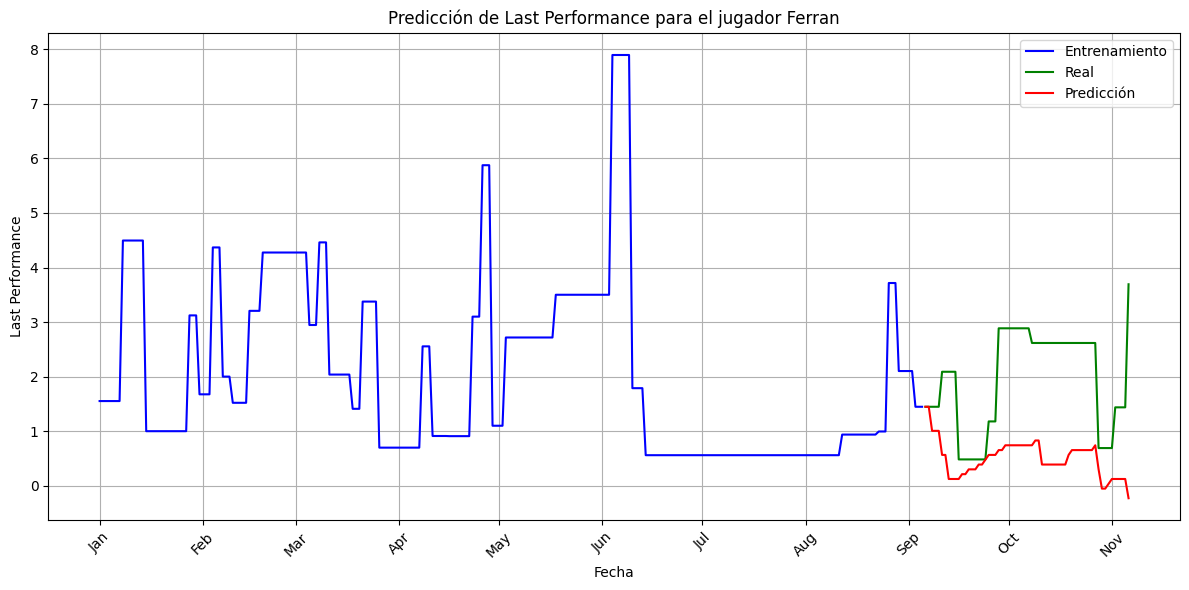

---------------------------Gerard Moreno----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=900.412, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=544.427, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=720.327, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1326.416, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=545.928, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=543.981, Time=0.58 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=869.394, Time=0.47 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=545.698, Time=0.94 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=545.740, Time=0.55 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=714.298, Time=0.45 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=547.569, Tim

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                  last_performance   No. Observations:                  224
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood                -270.188
Date:                           Mon, 18 Nov 2024   AIC                            550.375
Time:                                   19:20:34   BIC                            567.433
Sample:                                        0   HQIC                           557.261
                                           - 224                                         
Covariance Type:                             opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Sentimientos_acumulado     1.4110      0.261      5.412      0.000       0.900       1.922
ar.L1  

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


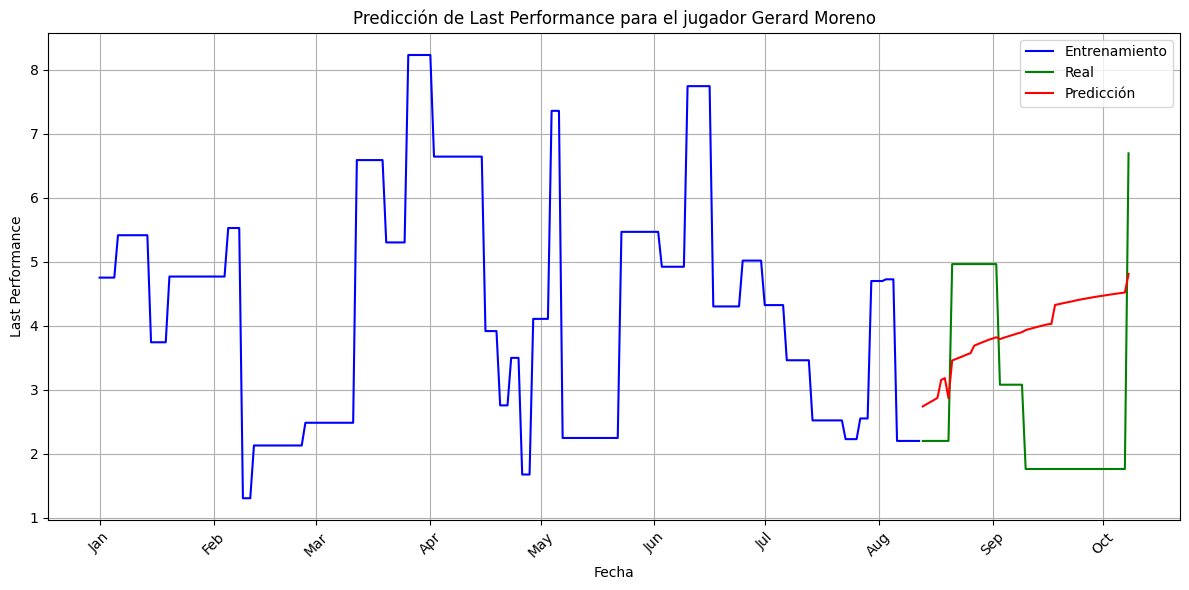

---------------------------Griezmann----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=668.183, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=672.183, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=672.183, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=666.185, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=670.183, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=670.183, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=672.182, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=670.183, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=670.183, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=672.183, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.932 seconds
                               SARIMAX Results                                
Dep. Variable:           

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

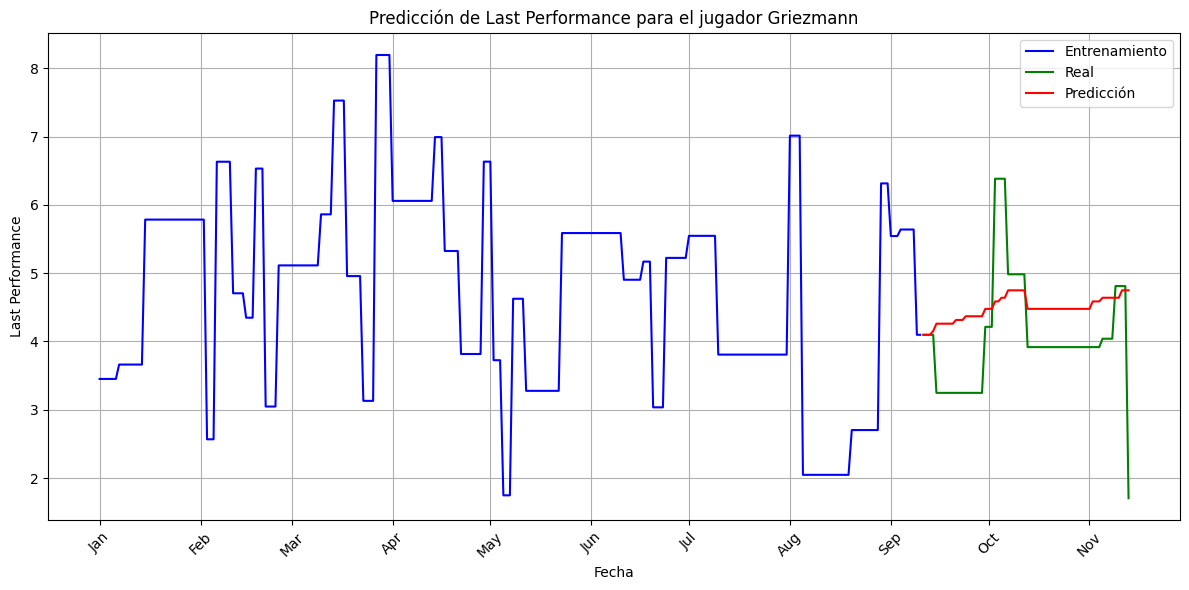

---------------------------Koundé----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=957.378, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=608.234, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=776.248, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1657.102, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=607.864, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=607.771, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=607.083, Time=0.55 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=609.093, Time=0.79 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=945.897, Time=0.11 sec
 ARIMA(2,0,0)(0,0,2)[7] intercept   : AIC=608.847, Time=0.33 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=608.887, Time=0.26 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=776.571, Time=0

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                       last_performance   No. Observations:                  254
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 7)   Log Likelihood                -305.597
Date:                                Mon, 18 Nov 2024   AIC                            621.195
Time:                                        19:20:43   BIC                            638.881
Sample:                                             0   HQIC                           628.310
                                                - 254                                         
Covariance Type:                                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Sentimientos_acumulado    -0.1690      0.148     -1.145   

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


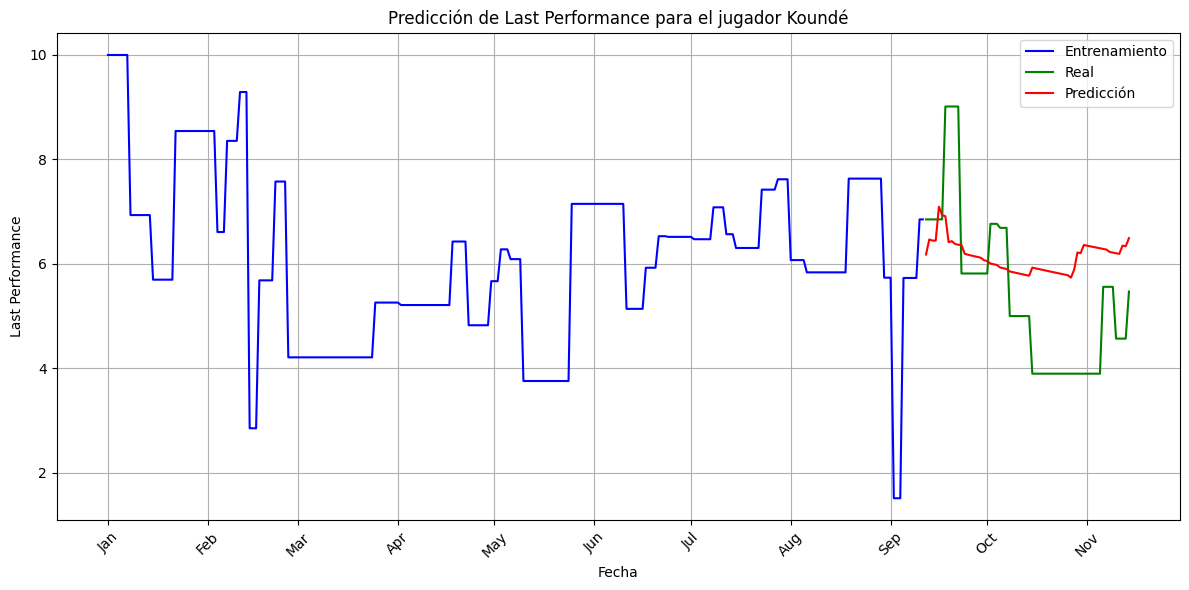

---------------------------Kubo----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=472.584, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=822.241, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=465.787, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=629.626, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1366.497, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=463.859, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=465.789, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=465.092, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=465.193, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=646.532, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=467.272, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=476.332, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] intercept
Total fi

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

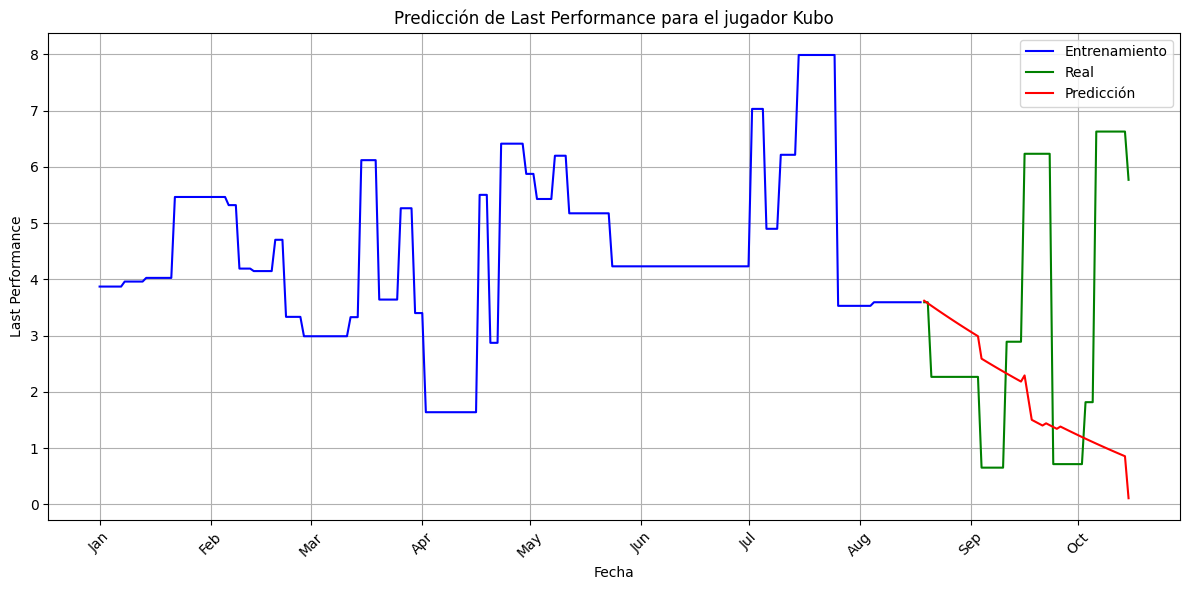

---------------------------Lamine Yamal----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=696.896, Time=1.38 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1060.898, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=692.409, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=859.709, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1440.886, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=690.418, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=692.408, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=694.030, Time=1.21 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=691.267, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=691.440, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=868.628, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=692.478, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=702.795, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] inter

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

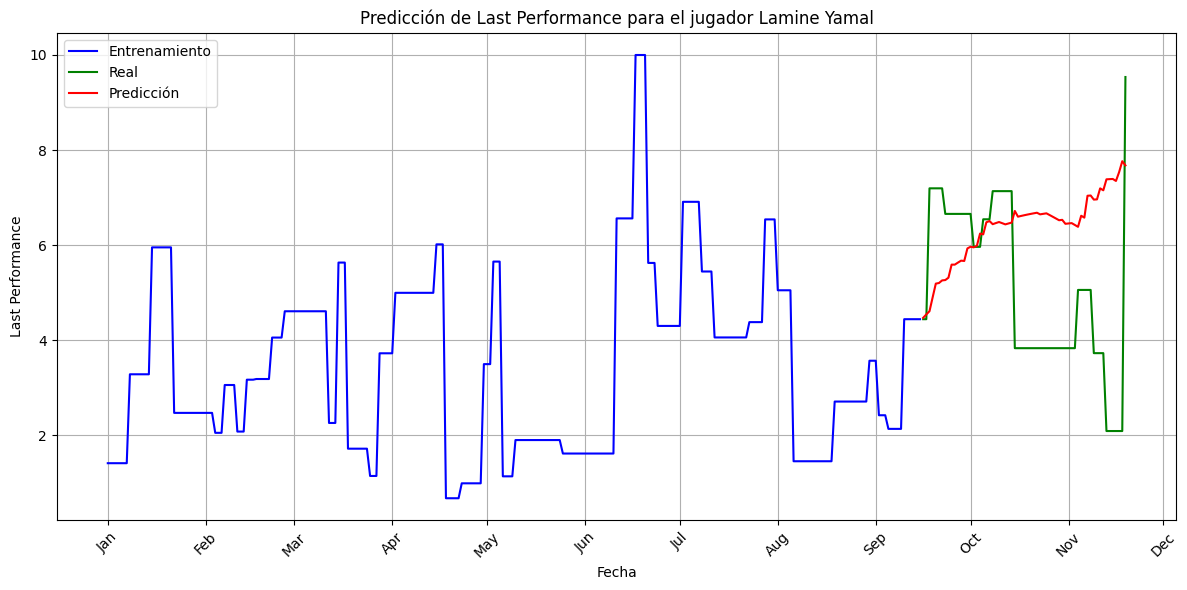

---------------------------Lewandowski----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=918.289, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=492.707, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=697.969, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1344.849, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=491.795, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=492.649, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=493.146, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=493.218, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=713.831, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=495.753, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=502.058, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] intercept
Total

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

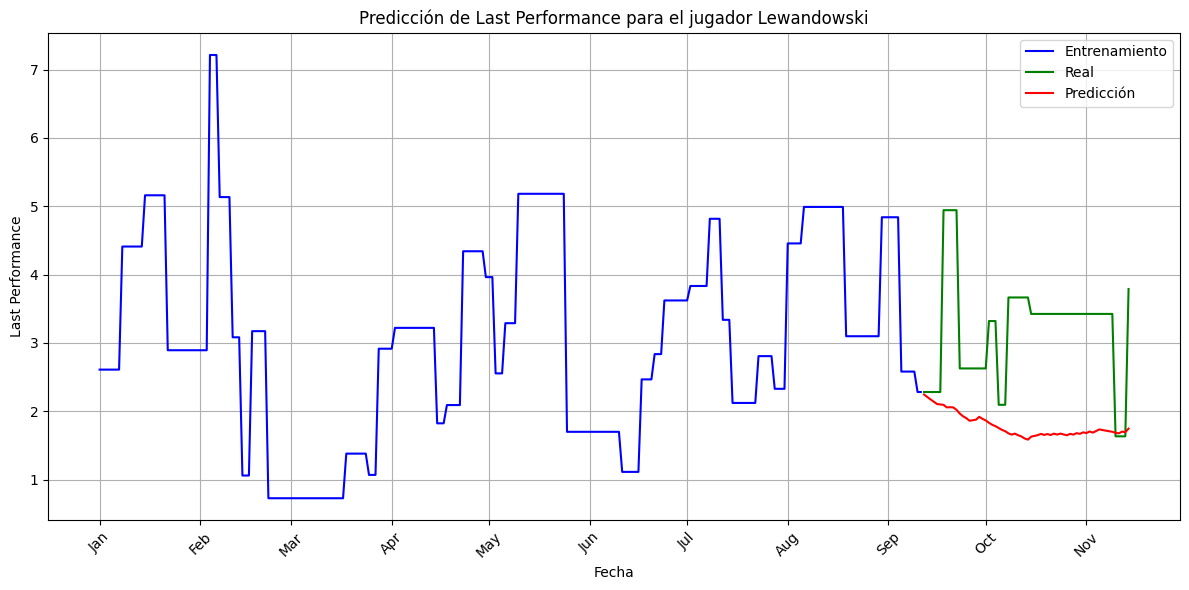

---------------------------Miguel Gutiérrez----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=276.795, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=269.345, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=273.198, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=273.166, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=267.384, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=271.198, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=271.166, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=272.525, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=271.345, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=271.345, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=273.345, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.550 seconds
                               SARIMAX Results                                
Dep. Variable:

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

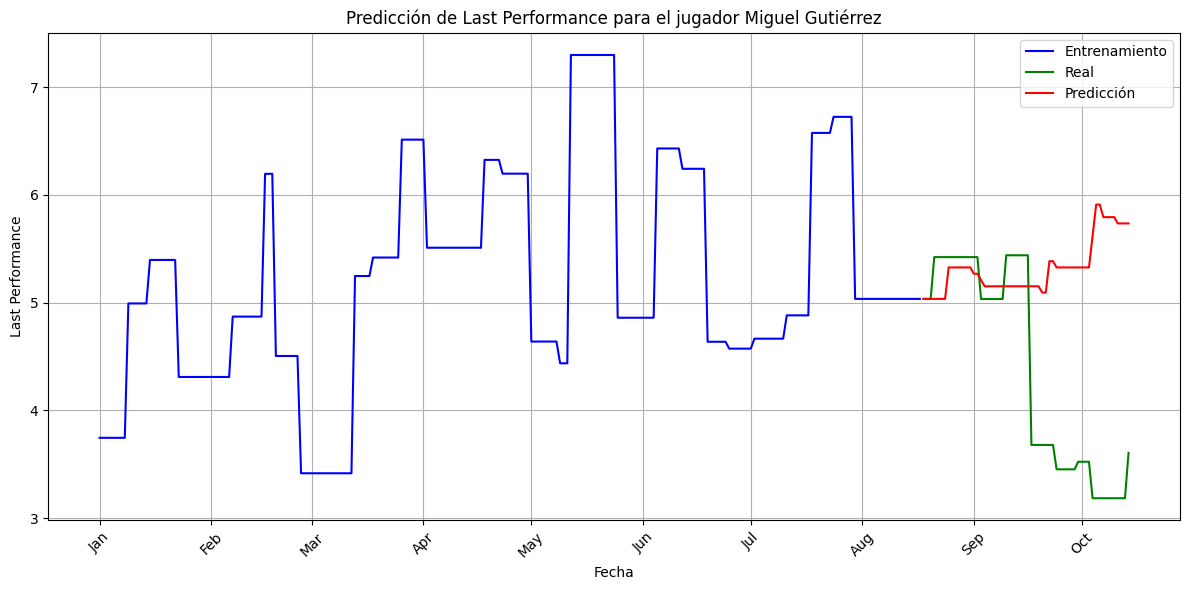

---------------------------Mikel Merino----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=940.803, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=500.634, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=689.670, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1553.953, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=507.350, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=502.002, Time=0.50 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=499.949, Time=0.13 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=501.878, Time=0.25 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=843.339, Time=0.05 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=501.699, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=501.738, Time

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

                                      SARIMAX Results                                      
Dep. Variable:                    last_performance   No. Observations:                  248
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 7)   Log Likelihood                -252.281
Date:                             Mon, 18 Nov 2024   AIC                            512.562
Time:                                     19:21:04   BIC                            526.615
Sample:                                          0   HQIC                           518.219
                                             - 248                                         
Covariance Type:                               opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Sentimientos_acumulado    -0.3401      0.160     -2.128      0.033      -0.653    

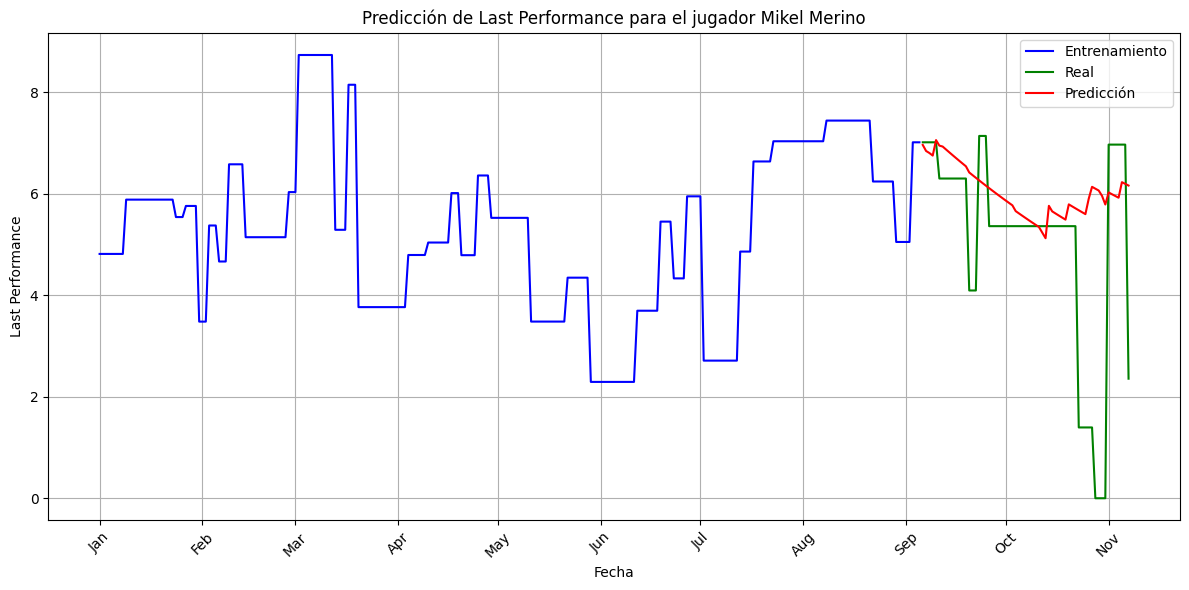

---------------------------Morata----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=489.665, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=492.756, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=492.648, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=487.669, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=490.766, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=490.662, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=489.446, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=491.665, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=491.665, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=493.665, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.970 seconds
                               SARIMAX Results                                
Dep. Variable:              

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

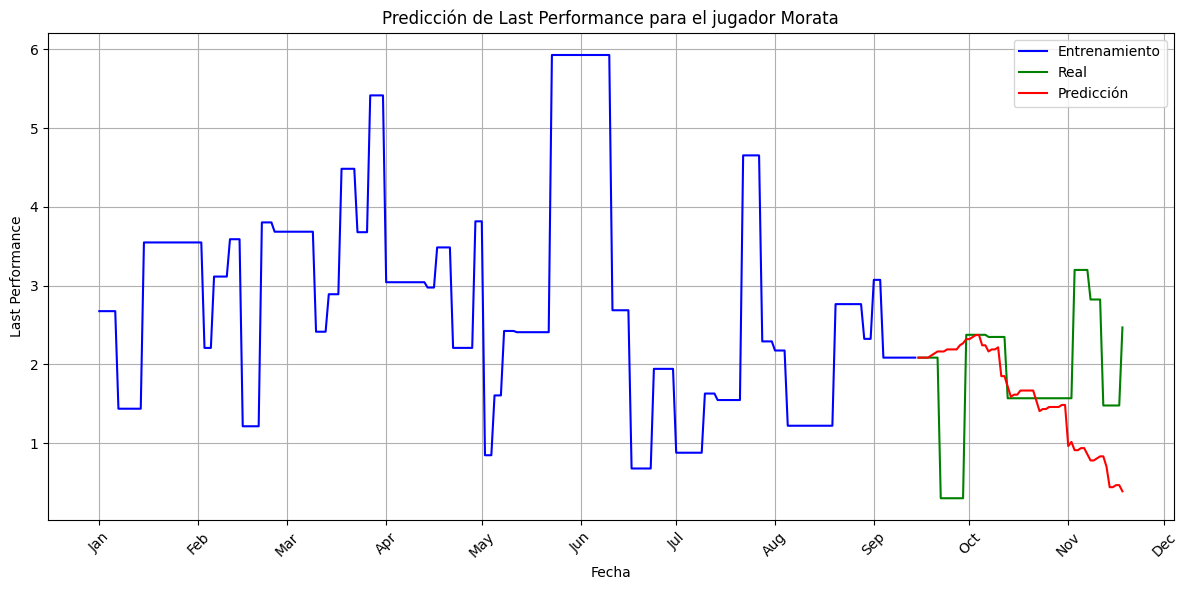

---------------------------Nico Williams----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1115.842, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=590.245, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=836.866, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1575.723, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=588.317, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=590.230, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=590.011, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=590.033, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=883.283, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=590.335, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=594.689, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] intercept
To

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

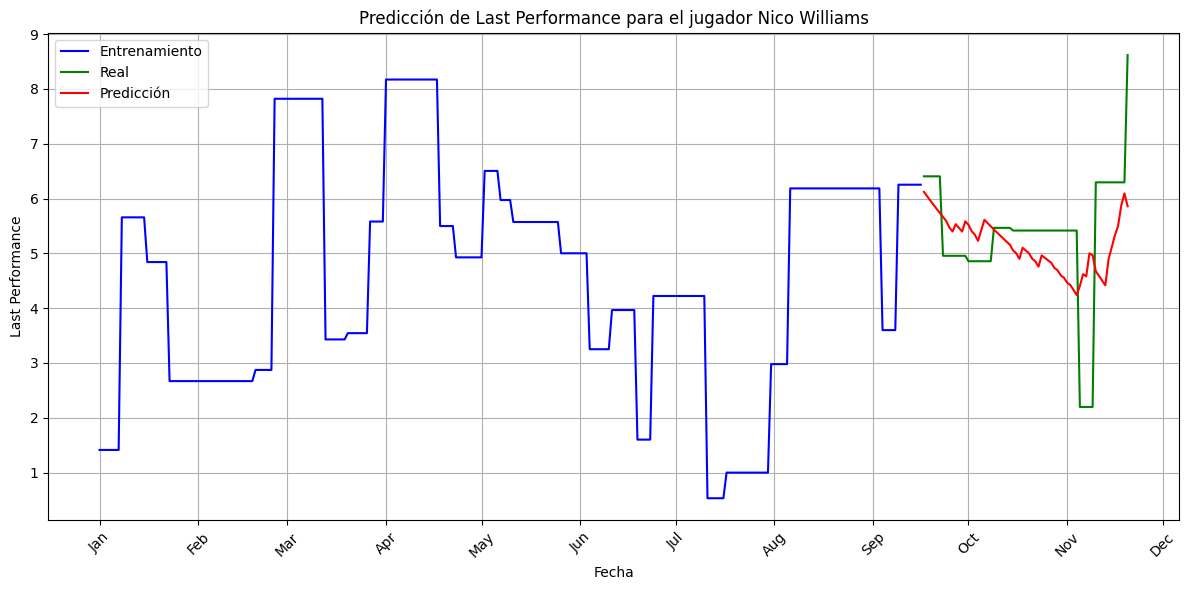

---------------------------Oscar Mingueza----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=897.027, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=597.387, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=732.047, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1420.750, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=596.840, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=597.328, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=597.449, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=597.669, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=730.051, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=600.214, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=612.575, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] intercept
To

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\si

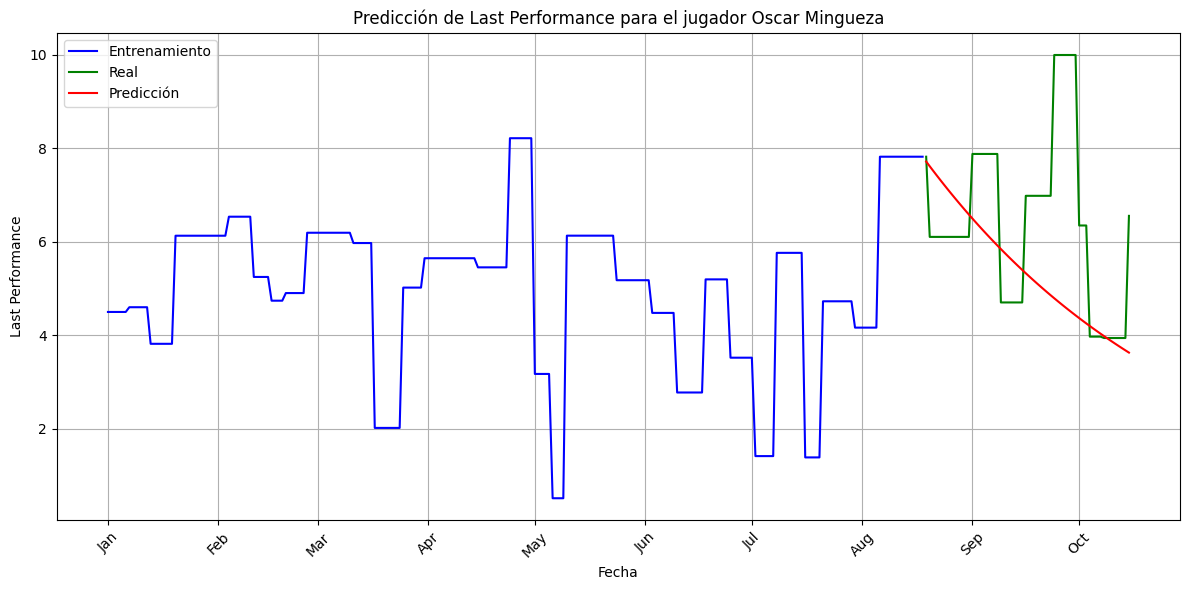

---------------------------Vinicius----------------------------
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=614.694, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=604.426, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=608.230, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=608.224, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=602.439, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=606.251, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=606.246, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=607.940, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=606.426, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=606.426, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=608.426, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.737 seconds
                               SARIMAX Results                                
Dep. Variable:        

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excepti

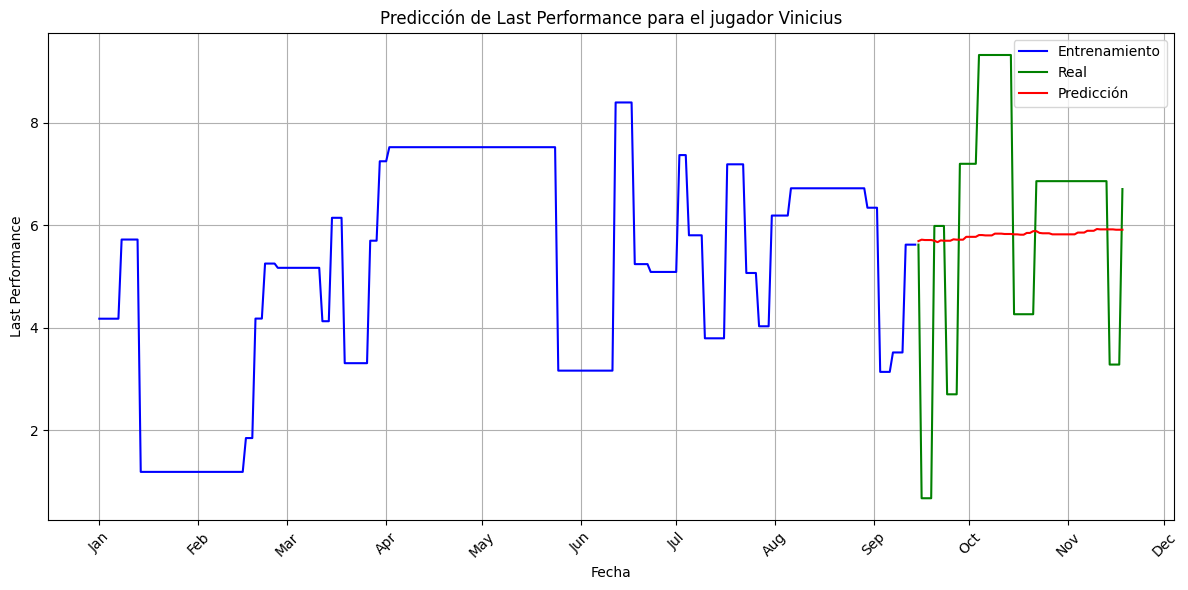

In [152]:
for jugador in df['Player'].unique():
    print(f"---------------------------{jugador}----------------------------")
    df_jugador = df[df['Player'] == jugador]
    predecir_last_performance(df_jugador)